In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,io,sys,glob, h5py, csv, time
import matplotlib.pyplot as plt
import json

from dlab import generalephys as ephys
from dlab import generalephys_mua as ephys_mua
#from neuropixels import cell_pairs as pairs

#from neuropixels import utils_pipeline as utils
#from neuropixels import analysis_pipeline as analysis

from dlab import analysis_pipeline as analysis
from dlab.continuous_traces import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import pearsonr, spearmanr, zscore
from itertools import combinations 
#from neuropixels import sorting_quality_editing as sq
from sklearn.manifold import TSNE
from scipy.cluster.vq import kmeans2
#from dlab import depth_estimation as depth
#from dlab import PCA as pca
from scipy import stats

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("white")
import warnings
warnings.filterwarnings('ignore')

In [2]:
def psth(df,df_reaches,start,end,binsize):

    tensor = []
    hists = []
    each_unit = []
    behavior = []
    units = []
    reach = []
    all_reach = []
    all_rastor = []
    peakt = []

    for i,times in enumerate(df.times): #compare that unit's spike times to each reach max
        t = np.array(times) #for reach unit create an array of that unit's spike times
        hists = []
        for j,tmax in enumerate(df_reaches.rMax_t): #for each unit 
            a = tmax+start
            b = tmax+end
            rd = np.array(t[(t >= a) & (t <= b)]) #find if that unit spiked within designated timeframes around reachmax
            edges=np.arange(a,b,binsize) #designated bins around this iteration of reachmax
            hist=np.histogram(rd,edges)[0] #bin spikes into timeframe
            
            #maxfr = np.max(hist)
            #print(maxfr)
            #maxfr_t = np.where(edges==maxfr)
            #print(maxfr_t)
            #hist=list(hist)
            #hist.extend([2])
            hists.append(hist) # kim changed to *0.5 5.23.23
            peakt.append(df.peakup[i])

        mn = np.mean(hists,axis=0)
        all_rastor.append(hists)
        all_reach.append(mn)
    return all_reach,all_rastor,peakt

# imports

In [3]:
folder = r'Y:\BIOElectricsLab\Kim\NPX_recordings\MOBPNPX_cohort2_10_2022'
df2 = pd.read_json(os.path.join(folder,'df_aligned.json'))
dfr2 = pd.read_json(os.path.join(folder,'df_reaches.json'))
df2 = df2[df2.group=='good']

In [4]:
dfg = pd.read_json(r'C:\Users\Kim\Documents\Data\gustavo_data\df_DG.json')
#dfg = dfg[dfg.cohort2=='Gustavo'][dfg.timepoint==2]
#dfd = dfg[dfg.timepoint==2][dfg.cohort2=='Dailey'][dfg.group=='good']
df1 = dfg[dfg.group=='good'][dfg.cohort2=='Dailey']
dfr1 = pd.read_json(r'Y:\BIOElectricsLab\Kim\DATAforanalysis\Dailey\df_reaches_061622.json')
#dfrg = pd.read_json(r'C:\Users\Kim\Documents\Data\gustavo_data\pipeline_inputs\df_reaches_MOBP_timepoint2.json')

In [5]:
df_align_all = [analysis.movement_mod(df1[df1.mouse==mouseid],dfr1[dfr1.mouse==mouseid]) for mouseid in dfr1.mouse.unique()]
df1 = pd.concat(df_align_all,ignore_index=True)

[11]
[12]
[20]
[22]
[24]
[]
[42]
[43]
[49]
[51]
[53]
[56]
[58]
[59]
[64]
[65]
[66]
[67]
[68]
[69]
[71]


In [184]:
df_run = df[df.mod_up=='yes'][df.epochFR>5].sort_values(by=['peakup'])

In [185]:
df_run = df_run.drop(['level_0'],axis=1)
df_run = df_run.reset_index()

In [191]:
avereach,raster,peaks = psth(df_run,dfr[20:],-.5,.5,0.001)

In [192]:
np.shape(dfr)

(40, 9)

# raster

In [81]:
df1 = df1.drop('level_0',axis=1)

In [4]:
df = df2[df2.mouse==96][df2.epochFR>5][df2.mod_up=='yes']
dfr = dfr2[dfr2.mouse==96]

In [5]:
df_run = df.sort_values(by=['peakup'])
df_run = df_run.reset_index()

In [6]:
avereach,raster,peaks = psth(df_run,dfr,-.5,.5,0.001)

In [14]:
np.shape(raster)

(26, 42, 999)

In [8]:
rast_maps = []
for i,rast in enumerate(raster):
        rast_maps.extend(rast)

In [15]:
np.shape(rast_maps)

(1092, 999)

In [9]:
new_rastmap = []
for i in rast_maps:
    new_rast = []
    for j in i:
        if j > 0:
            new_rast.append(1)
        if j == 0:
            new_rast.append(0)
    new_rastmap.append(new_rast)

In [10]:
clust = []
for i in np.arange(1,np.shape(dfr)[0]+1,1):
    clust.extend(np.ones(np.shape(df_run)[0])*i)

In [11]:
df_clust = pd.DataFrame(data=clust,columns=['clust'])

In [12]:
df_clust['rast'] = new_rastmap

In [13]:
df_clust

,clust,rast
0,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
1087,42.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1088,42.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1089,42.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1090,42.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


21


<Figure size 432x288 with 0 Axes>

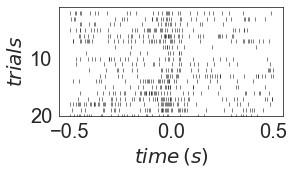

36


<Figure size 432x288 with 0 Axes>

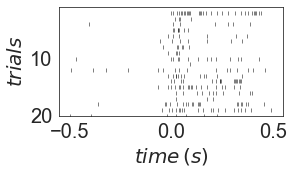

39


<Figure size 432x288 with 0 Axes>

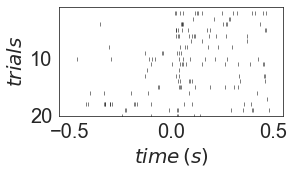

40


<Figure size 432x288 with 0 Axes>

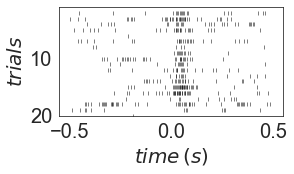

41


<Figure size 432x288 with 0 Axes>

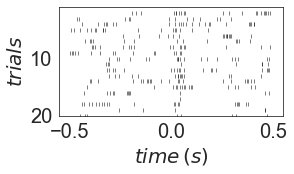

43


<Figure size 432x288 with 0 Axes>

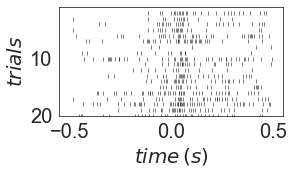

In [330]:
linewidth = 0.5
markersize=4
for i,rast in enumerate(raster):
    good_list = [21,36,39,40,41,43]
    if i in good_list:
        plt.figure()
        plt.subplots(figsize=(4, 2))
        axes=plt.gca()
        print(i)
        for j,r in enumerate(rast):
            x = np.arange(-0.5,0.5,0.001)
            y = np.array(r)
            axes.plot(x[:-1], y*(j+2),"|",markersize=markersize,mew=linewidth,color='black')
            axes.set_xlabel(r'$time \/ (s)$',fontsize=20)
            axes.set_ylabel(r'$trials$',fontsize=20)
            axes.tick_params(axis='both',labelsize=20)
            axes.locator_params(axis="both", integer=True, tight=True)
        plt.ylim(np.shape(dfr[:20])[0],1)
        path = r'Y:\BIOElectricsLab\Kim\ConferenceGrantFigs\MyelinGrant\cntrl_raster\selectreaches'
        plt.savefig(os.path.join(path,str(i) + '.svg'))
        plt.show()
        plt.close()

# single trial raster

In [110]:
np.shape(raster)

(101, 31, 999)

In [131]:
linewidth = 0.5
markersize=5
#for r,reach in enumerate(dfr):
#    plt.figure()
#    plt.subplots(figsize=(8, 6))
#    axes=plt.gca()
#    idk = []
#    for n,rast in enumerate(raster):
#        x = np.arange(-0.5,0.5,0.001)
#        y = np.array(rast[r])
#        axes.plot(x[:-1], y*(n+2),"o",markersize=markersize,mew=linewidth,color='black')
#        axes.set_xlabel(r'$time \/ [ms]$',fontsize=20)
#        axes.set_ylabel(r'$neurons$',fontsize=20)
#        axes.tick_params(axis='both',labelsize=20)
#        plt.ylim(np.shape(raster)[0],1)
#        plt.axvline(0)
#        idk.append(y)
#    plt.show()
#    plt.close()
    #sns.heatmap(idk)
    #plt.show()
    #plt.close()

# reliability fig (komiyama)

In [357]:
#df1 = df1.drop('level_0',axis=1)
df = df2[df2.mouse==96][df2.epochFR>5][df2.mod_up=='yes']
dfr = dfr2[dfr2.mouse==96]

In [307]:
#df1 = df1.drop('level_0',axis=1)
df = df1[df1.mouse==67][df1.epochFR>5][df1.group=='good'][df1.mod_up=='yes']
dfr = dfr1[dfr1.mouse==67]

In [361]:
np.shape(dfr)

(42, 9)

In [358]:
df_run = df.sort_values(by=['peakup'])
df_run = df_run.reset_index()

In [359]:
np.shape(df)

(26, 30)

In [370]:
avereach,raster,peaks = psth(df_run,dfr[22:],-.5,.5,0.001)

In [371]:
#good_list = [36,40,41,43] #cntrl
good_list = [5,7,9,14] #cup
rast_map = []
for i,rast in enumerate(raster):
    if i in good_list:
        rast_map.append(rast)

In [372]:
np.shape(rast_map)

(4, 20, 999)

In [373]:
rast_maps = []
for i,rast in enumerate(rast_map):
        rast_maps.extend(rast)

In [374]:
np.shape(rast_maps)

(80, 999)

In [375]:
#new_rastmap = []
#for i in rast_map:
 #   new_rast = []
 #   for j in i:
#        if j > 0:
#            new_rast.append(1)
#        if j == 0:
#            new_rast.append(0)
#    new_rastmap.append(new_rast)

In [376]:
clust = []
for i in np.arange(1,np.shape(df_run[:4])[0]+1,1):
    clust.extend(np.ones(np.shape(dfr[22:])[0])*i)

df_clust = pd.DataFrame(data=clust,columns=['clust'])

In [377]:
df_clust = pd.DataFrame(data=clust,columns=['clust'])

In [378]:
df_clust['rast'] = rast_maps

<Figure size 432x288 with 0 Axes>

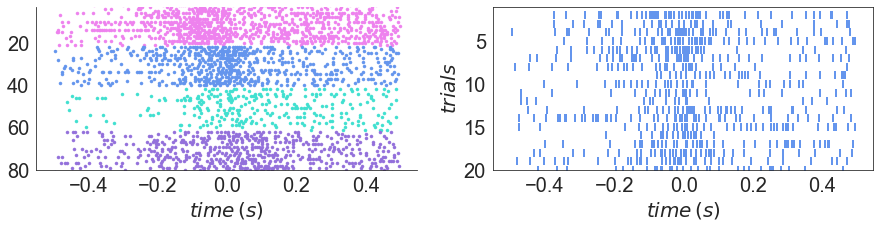

In [381]:
colors = ['mediumpurple','violet','cornflowerblue','turquoise','mediumpurple','lightgreen','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue','mediumpurple','lightgreen','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue']
#colors = ['mediumpurple','salmon','cornflowerblue','lightgreen','turquoise','mediumpurple','salmon','cornflowerblue','lightgreen','turquoise','mediumpurple','salmon','cornflowerblue','lightgreen','turquoise','mediumpurple','salmon','cornflowerblue','lightgreen','turquoise','mediumpurple','salmon']
plt.figure()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,3),sharey=False)
#axes=plt.gca()
linewidth = 0.5
markersize=3
for i,rast in enumerate(df_clust.rast):
    cl = int(df_clust.clust[i])
    color = colors[cl]
    x = np.arange(-0.5,0.5,0.001)
    y = np.array(rast)
    ax1.plot(x[:-1], y*(i+2),"o",markersize=markersize,mew=linewidth,color=color)
    ax1.set_xlabel(r'$time \/ (s)$',fontsize=20)
    #axes.set_ylabel(r'$trials$',fontsize=20)
    ax1.tick_params(axis='both',labelsize=20)
    #axes.axvline(0,linestyle='--',color='grey')
    ax1.spines['top'].set_visible(False);axes.yaxis.set_ticks_position('left')
    ax1.spines['right'].set_visible(False);axes.xaxis.set_ticks_position('bottom')
    ax1.set_ylim(np.shape(rast_maps)[0],3)

linewidth = 2
markersize=8
for i,rast in enumerate(raster):
    good_list = [7]
    if i in good_list:
        for j,r in enumerate(rast):
            x = np.arange(-0.5,0.5,0.001)
            y = np.array(r)
            ax2.plot(x[:-1], y*(j+2),"|",markersize=markersize,mew=linewidth,color='cornflowerblue')
            ax2.set_xlabel(r'$time \/ (s)$',fontsize=20)
            ax2.set_ylabel(r'$trials$',fontsize=20)
            ax2.tick_params(axis='both',labelsize=20)
            ax2.locator_params(axis="both", integer=True, tight=True)
        ax2.set_ylim(20,1)
        path = r'Y:\BIOElectricsLab\Kim\ConferenceGrantFigs\MyelinGrant\cntrl_raster\selectreaches'
        #plt.savefig(os.path.join(path,str(i) + '.svg'))
#plt.show()
#plt.close() 
    
    
#plt.savefig(r'C:\Users\Kim\Documents\conferences\ARMartin\testfog2.svg')
plt.savefig(r'Y:\BIOElectricsLab\Kim\ConferenceGrantFigs\MyelinGrant\cup_raster\komiyamafig.svg')
plt.show()


In [ ]:
colors = ['mediumpurple','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue','mediumpurple','lightgreen','cornflowerblue','violet','turquoise','mediumpurple','lightgreen','cornflowerblue']
#colors = ['mediumpurple','salmon','cornflowerblue','lightgreen','turquoise','mediumpurple','salmon','cornflowerblue','lightgreen','turquoise','mediumpurple','salmon','cornflowerblue','lightgreen','turquoise','mediumpurple','salmon','cornflowerblue','lightgreen','turquoise','mediumpurple','salmon']
plt.figure()
plt.subplots(figsize=(8,4))
axes=plt.gca()
linewidth = 0.5
markersize=3
for i,rast in enumerate(df_clust.rast):
    cl = int(df_clust.clust[i])
    color = colors[cl]
    x = np.arange(-0.5,0.5,0.001)
    y = np.array(rast)
    axes.plot(x[:-1], y*(i+2),"o",markersize=markersize,mew=linewidth,color=color)
    axes.set_xlabel(r'$time \/ (s)$',fontsize=20)
    #axes.set_ylabel(r'$trials$',fontsize=20)
    axes.tick_params(axis='both',labelsize=20)
    #axes.axvline(0,linestyle='--',color='grey')
    axes.spines['top'].set_visible(False);axes.yaxis.set_ticks_position('left')
    axes.spines['right'].set_visible(False);axes.xaxis.set_ticks_position('bottom')
#plt.savefig(r'C:\Users\Kim\Documents\conferences\ARMartin\testfog2.svg')
plt.ylim(np.shape(rast_maps)[0],3)
#plt.savefig(r'Y:\BIOElectricsLab\Kim\ConferenceGrantFigs\MyelinGrant\cntrl_raster\komiyamafig.png')
plt.show()

In [382]:
from affinewarp import SpikeData

In [383]:
SpikeData

affinewarp.spikedata.SpikeData

In [388]:
raw_spikes = SpikeData(*np.where(binned), 0, binned.shape[1]).select_neurons(n)

NameError: name 'n' is not defined

In [385]:
SpikeData

affinewarp.spikedata.SpikeData

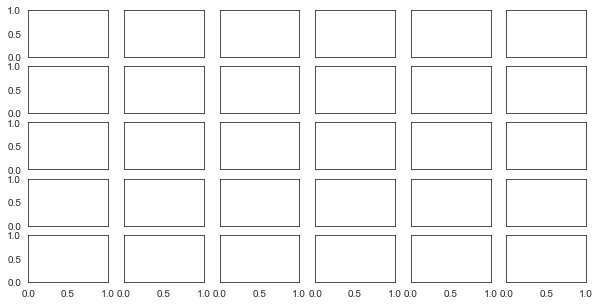

In [390]:
fig, axes = plt.subplots(5, 6, sharex=True, sharey=True, figsize=(10, 5))
for n, axr in enumerate(axes):
    raw_spikes = SpikeData(*np.where(binned), 0, binned.shape[1]).select_neurons(n)
    print(raw_spikes)

In [387]:
from affinewarp.datasets import piecewise_warped_data
binned, true_model = piecewise_warped_data(
    n_knots=1,
    n_trials=100,
    n_timepoints=150,
    n_neurons=100,
    clip_y_knots=False,
    template_scale=1.0,
    template_drop=.9,
    template_smoothness=2,
    noise_type="poisson",
    seed=1234)